In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast


from sklearn.model_selection import train_test_split, validation_curve
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import norm
from scipy.optimize import minimize


df = pd.read_csv(r"C:\Users\jjap2\Poleto SCE\Poleto-SCE\dond_game_data.csv")

In [2]:
#cleaning cell
df["Remaining Values"] = df["Remaining Values"].apply(ast.literal_eval)

all_values = set()
for values in df["Remaining Values"]:
    all_values.update(values)

for value in sorted(all_values):
    df[f"Case_{value}"] = df["Remaining Values"].apply(lambda x: 1 if value in x else 0)

exclude = ["Remaining Values", "Contestant Name", "Contestant Gender", "Contestant Race", "Amount Won"]
df = df.drop(columns=exclude)

df = df[(df["Postgame"] != 1) & (df["Offer"] != 0)]

In [ ]:
# Remove first round (as per the paper)
df = df[df["Round"] >= 2]

# log-likelihood function
def negative_log_likelihood(params, df):
    sigma, delta = params
    
    if sigma <= 0 or delta <= 0:
        return np.inf 
    
    # z-scores
    z_scores = (df["Offer"] - df["Board Average"]) / (delta * sigma)
    
    # likelihood
    likelihoods = norm.cdf(z_scores)

    epsilon = 1e-10
    likelihoods = np.maximum(likelihoods, epsilon)
    
    # the negative log-likelihood for rounds where Deal = 1
    neg_log_likelihood = -np.log(likelihoods[df["Deal"] == 1]).sum()
    
    return neg_log_likelihood

initial_params = [1, 1]  # Initial guesses for sigma and delta

# Optimize
result = minimize(negative_log_likelihood, initial_params, args=(df,), method="Nelder-Mead")

# Get values
optimal_sigma, optimal_delta = result.x

print("Optimal sigma:", optimal_sigma)
print("Optimal delta:", optimal_delta)
print("Minimum negative log-likelihood:", result.fun)

Optimal sigma: 2.5161822084104606
Optimal delta: 2.434834222099739
Minimum negative log-likelihood: 1635.6961405726724


In [ ]:
def utility(x, alpha, beta):
    return (1 - np.exp(-alpha * x ** (1 - beta))) / alpha

# ranges
alphas = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1]
betas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


results = []

for alpha in alphas:
    for beta in betas:
        # utility values for each row
        offer_utils = df["Offer"].apply(lambda x: utility(x, alpha, beta))
        board_avg_utils = df["Board Average"].apply(lambda x: utility(x, alpha, beta))

        # utility ratio
        # ratio >= 1, acceptance is rational
        utility_ratios = offer_utils / board_avg_utils.replace(0, np.nan)

        rational_decisions = offer_utils >= board_avg_utils
        followed_rationality = rational_decisions == df["Deal"]

        avg_ratio = np.nanmean(utility_ratios)
        rationality_rate = followed_rationality.mean() * 100

        # results
        results.append({
            "Alpha": alpha,
            "Beta": beta,
            "Avg Utility Ratio": avg_ratio,
            "Rationality Rate (%)": rationality_rate
        })


results_df = pd.DataFrame(results)
# df to matrix
utility_ratio_pivot = results_df.pivot(index="Alpha", columns="Beta", values="Avg Utility Ratio")
rationality_pivot = results_df.pivot(index="Alpha", columns="Beta", values="Rationality Rate (%)")


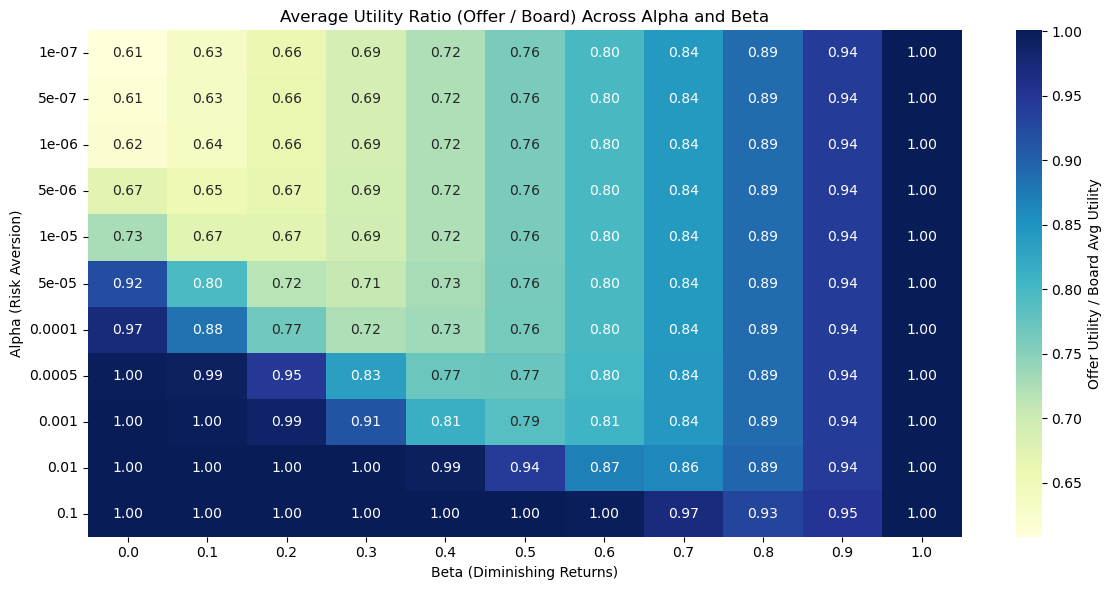

In [5]:
plt.figure(figsize=(12, 6))
sns.heatmap(utility_ratio_pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "Offer Utility / Board Avg Utility"})
plt.title("Average Utility Ratio (Offer / Board) Across Alpha and Beta")
plt.xlabel("Beta (Diminishing Returns)")
plt.ylabel("Alpha (Risk Aversion)")
plt.tight_layout()
plt.show()

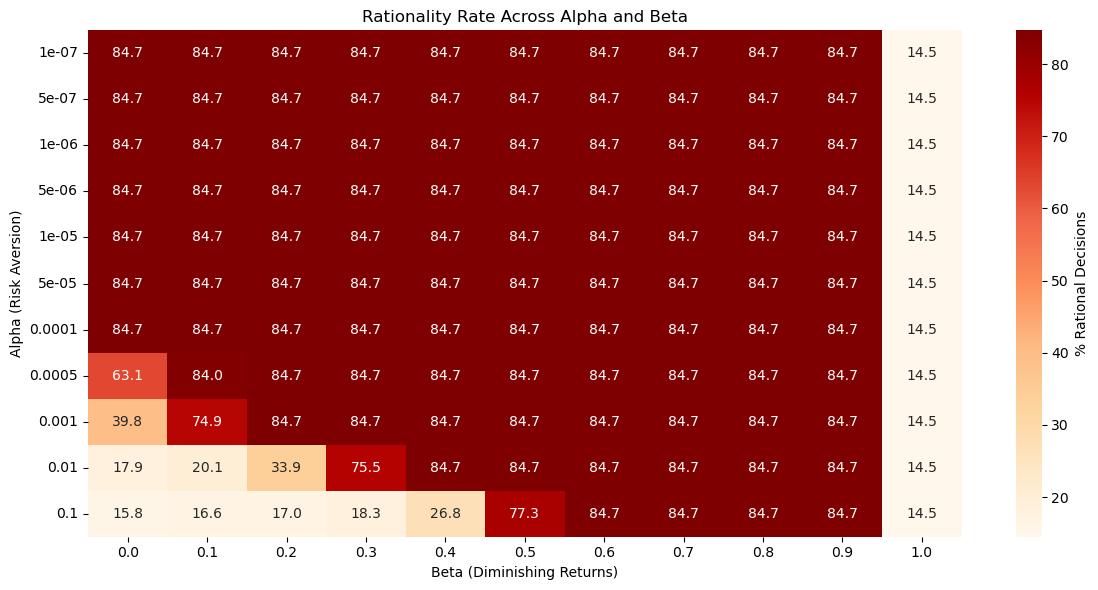

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(rationality_pivot, annot=True, fmt=".1f", cmap="OrRd", cbar_kws={"label": "% Rational Decisions"})
plt.title("Rationality Rate Across Alpha and Beta")
plt.xlabel("Beta (Diminishing Returns)")
plt.ylabel("Alpha (Risk Aversion)")
plt.tight_layout()
plt.show()

In [7]:
def neg_log_likelihood(params, df):
    alpha, beta, sigma = params
    if alpha <= 0 or not (0 <= beta <= 1) or sigma <= 0:
        return np.inf
    
    u_offer = utility(df["Offer"], alpha, beta)
    u_board = utility(df["Board Average"], alpha, beta)
    diff = u_offer - u_board

    probs = norm.cdf(diff / sigma)
    probs = np.where(df["Deal"], probs, 1 - probs)
    
    probs = np.clip(probs, 1e-6, 1 - 1e-6)
    log_likelihood = np.sum(np.log(probs))
    return -log_likelihood

initial_guess = [1e-4, 0.5, 1.0]
bounds = [(1e-8, 1e-2), (0, 1), (1e-4, 10)]

result = minimize(neg_log_likelihood, initial_guess, args=(df,), bounds=bounds)

print("Optimal alpha:", result.x[0])
print("Optimal beta:", result.x[1])
print("Optimal sigma:", result.x[2])
print("Minimum negative log-likelihood:", result.fun)

Optimal alpha: 0.01
Optimal beta: 0.5663298254695923
Optimal sigma: 5.873996791232354
Minimum negative log-likelihood: 211.00036287916163
